In [1]:
import multiprocessing as mp
import sys

import datamol as dm
import lohi_splitter as lohi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polaris as po
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
import seaborn as sns
from splito._scaffold_split import get_scaffold
from tqdm import tqdm

sys.path.append('../src')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize_smiles

[20:23:00] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.WARNING)

In [3]:
data = pd.read_csv('~/data/ExternalData/cleaned_solubility_dataset.csv')
data

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Cleaned_SMILES
0,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,62,2,0,1,3,29.10,75.183563,2.582996,511.229248,O=C1Nc2cccc3cccc1c23
1,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,46,1,0,0,1,17.07,58.261134,3.009782,202.661065,O=Cc1ccc(Cl)cc1
2,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,164,2,4,4,6,56.60,183.183268,1.084427,769.899934,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...
3,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,...,46,1,0,0,1,0.00,55.836626,3.070761,211.033224,C=Cc1cccc(C)c1
4,A-11,3-(3-ethylcyclopentyl)propanoic acid,InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...,WVRFSLWCFASCIS-UHFFFAOYSA-N,CCC1CCC(CCC(O)=O)C1,-3.286116,0.000000,1,G1,170.252,...,70,0,1,1,1,37.30,73.973655,2.145839,153.917569,CCC1CCC(CCC(=O)O)C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8905,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,106,1,0,0,1,41.57,115.300645,2.394548,374.236894,CCCCNc1ccc(C(=O)OCCN(C)C)cc1
8906,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,170,1,0,3,4,181.62,182.429237,2.047922,1148.584975,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...
8907,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,60,1,0,0,1,20.23,67.685405,3.092720,251.049732,Cc1ccc(C(C)C)c(O)c1
8908,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,180,2,0,0,2,63.95,198.569223,2.023333,938.203977,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...


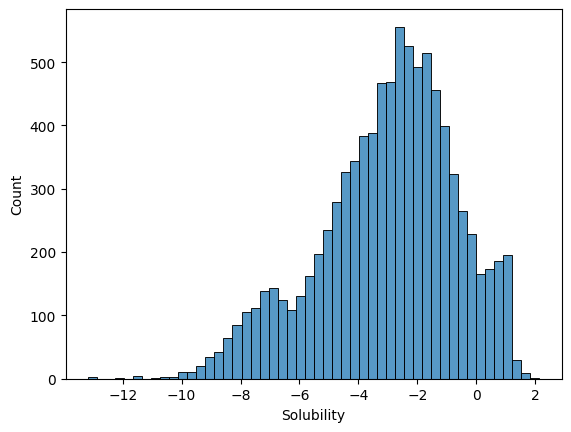

In [4]:
sns.histplot(data, x='Solubility', bins=50);

In [5]:
with mp.Pool(mp.cpu_count()) as pool:
    data['smiles'] = list(tqdm(pool.imap(standardize_smiles, data['SMILES']), total=len(data)))

 41%|████      | 3657/8910 [00:00<00:01, 3788.51it/s][20:23:01] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:23:01] Explicit valence for atom # 1 N, 4, is greater than permitted
100%|██████████| 8910/8910 [00:02<00:00, 3602.47it/s]


In [6]:
print(f"Broken: {data['smiles'].isna().sum() / len(data):.2%}")

Broken: 0.99%


In [7]:
data = data[~data['smiles'].isna()].reset_index(drop=True)
data.shape

(8822, 28)

## Data splits

In [8]:
data = data.rename({'Solubility': 'logS'}, axis=1)
data = data[['smiles', 'logS']]

In [28]:
train = pd.read_csv('~/data/splits/hi/train.tsv', sep='\t')
train = train[['smiles', 'logS']]
valid = pd.read_csv('~/data/splits/hi/valid.tsv', sep='\t')
valid = valid[['smiles', 'logS']]
full_internal_train = pd.read_csv('~/data/train.tsv', sep='\t')
full_internal_train = full_internal_train[['smiles', 'logS']]

In [19]:
with mp.Pool(mp.cpu_count()) as pool:
    data_fps = np.array(list(tqdm(pool.imap(ECFP_from_smiles, data['smiles']), total=len(data))))
    valid_fps = np.array(list(tqdm(pool.imap(ECFP_from_smiles, valid['smiles']), total=len(valid))))

100%|██████████| 308/308 [00:00<00:00, 7048.75it/s]


In [20]:
data2valid_dists = tanimoto_similarity(data_fps, valid_fps)
data2valid_dists = data2valid_dists.max(axis=1)

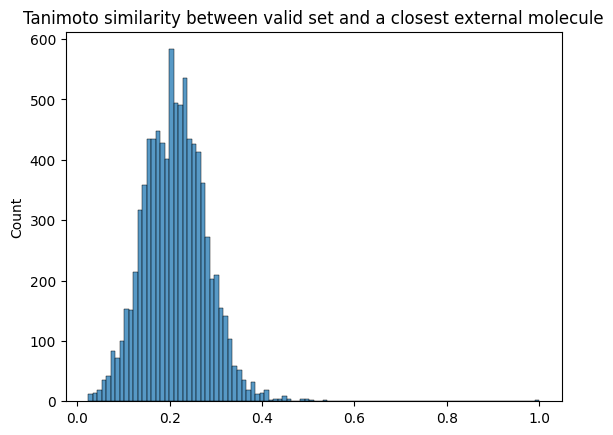

In [21]:
sns.histplot(data2valid_dists, bins=100);
plt.title('Tanimoto similarity between valid set and a closest external molecule');

In [22]:
train_with_external = pd.concat([train, data]).reset_index(drop=True)
train_with_external.shape

(10089, 2)

In [23]:
train_with_external

,smiles,logS
0,O=C(NCCc1ccc2c(c1)OCO2)C1CCCC1,1.624179
1,CCc1nc(NC(=O)c2ccccc2F)sc1C,1.361917
2,O=C(NCc1cccc(F)c1)c1[nH]nnc1-c1ccccc1,1.321184
3,Cc1ccc(-c2noc3nc(C)cc(C(=O)O)c23)cc1,1.871047
4,CN1CCC(NC(=O)COc2ccc(C#N)cc2)CC1,1.546296
...,...,...
10084,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
10085,[H][C@]12C[C@@]3([H])[C@H](N(C)C)C(O)=C(C(N)=O...,-2.930000
10086,Cc1ccc(C(C)C)c(O)c1,-2.190000
10087,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


In [29]:
all_data = pd.concat([full_internal_train, data]).reset_index(drop=True)
all_data.shape

(10400, 2)

In [30]:
train_with_external.to_csv('~/data/splits/hi/train_with_external.tsv', sep='\t', index=False)
all_data.to_csv('~/data/internal_external.tsv', sep='\t', index=False)